<a href="https://colab.research.google.com/github/xzplayer/PyTorch/blob/main/Cifar_10_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gen AI HW Variational Autoencoders
# Andy Oviedo 411121379



# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Hyperparameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
batch_size = 32
learning_rate = 0.001
weight_decay = 0.0001
beta = 1.0              # KL-loss weight
epochs = 150
factor = 0.9
patience = 11
threshold = 0.001


# Data Preparation

In [ ]:
# 1. Define transformations (convert to tensor, normalize, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5),  # mean for RGB channels
                         (0.5, 0.5, 0.5))  # std for RGB channels
])


In [ ]:
# 2. Download and load the training dataset
trainset_full = torchvision.datasets.CIFAR10(
    root='./data',          # Directory to store the dataset
    train=True,             # Training set
    download=True,          # Download if not already
    transform=transform     # Apply transformation
)

# --- Split training set into Train (90%) and Validation (10%) ---
train_size = int(0.9 * len(trainset_full))
val_size = len(trainset_full) - train_size

trainset, valset = torch.utils.data.random_split(trainset_full, [train_size, val_size])

# 3. Create DataLoaders for batching and shuffling
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    valset, batch_size=batch_size, shuffle=False, num_workers=2
)

In [ ]:
# 4. Same for the test dataset
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,            # Test set
    download=True,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Visualize Some Images

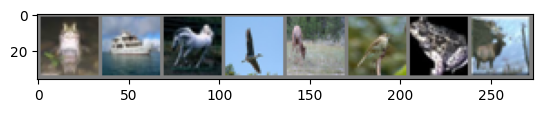

frog  ship  horse bird  deer  bird  frog  deer 


In [ ]:
# 5. CIFAR-10 has 10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Hout = ((Hin-Kernal+2*Padding)/Stride)+1
        # Input shape will be B,3,32,32 -> B,C,H,W
        self.encoder = nn.Sequential(

          nn.Conv2d(3,32,3,1,padding=1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),

          nn.Conv2d(32,64,3,1,padding=1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(),

          nn.Conv2d(64,64,3,2,padding=1), # After this layer input will be B,64,16,16
          nn.BatchNorm2d(64),
          nn.LeakyReLU(),

          nn.Conv2d(64,64,3,1,padding=1), # After this later input will be B,64,16,16
          nn.BatchNorm2d(64),
          nn.LeakyReLU(),

          nn.Conv2d(64,128,3,1,padding=1), # After this layer input will be B,128,16,16
          nn.BatchNorm2d(128),
          nn.LeakyReLU(),

          nn.Conv2d(128,128,3,2,padding=1), # After this layer input will be B,128,8,8
          nn.BatchNorm2d(128),
          nn.LeakyReLU(),

          nn.Conv2d(128,128,3,2,padding=1), # After this layer input will be B,128,4,4
          nn.BatchNorm2d(128),
          nn.LeakyReLU(),

          nn.Conv2d(128,128,3,1,padding=1), # After this layer input will be B,128,4,4
          nn.BatchNorm2d(128),
          nn.LeakyReLU(),

          nn.Flatten(start_dim=1, end_dim=-1)

        )

        self.z_mu = nn.Linear(128*4*4, latent_dim)
        self.z_logvar = nn.Linear(128*4*4, latent_dim)

    def forward(self,x):
        x = self.encoder(x)
        z_mean = self.z_mu(x)
        z_logvar = self.z_logvar(x)
        return z_mean,z_logvar

# Sampling

In [ ]:
class Sampling(nn.Module):
    def _init_(self):
      super()._init_()

    def forward(self,z_mean,z_logvar):
      batch_size,dim = z_mean.shape
      epsilon = torch.randn(batch_size,dim,device=z_mean.device)
      return z_mean + torch.exp(0.5*z_logvar)*epsilon

# Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 128*4*4),
            nn.BatchNorm1d(128*4*4),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128,128,kernel_size=3,stride=2,padding=1,output_padding=1), #4->8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128,128, 3, 1, 1),  # refine details
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1), #8->16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64,64, 3, 1, 1),  # refine details
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1), #16->32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),  # refine details
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 128, 4, 4)   # 🔥 this is the crucial reshape
        x = self.decoder(x)
        return x



# Loss Function

In [ ]:
def KL_Divergence_Loss(z_mean,z_logvar):
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean**2 - torch.exp(z_logvar), dim=1)
    return kl_loss.mean()

criterion = nn.MSELoss(reduction='sum')

# Full Autoencoder

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sampling_layer = Sampling()

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        kl_loss = KL_Divergence_Loss(z_mean, z_logvar)
        z_sample = self.sampling_layer(z_mean, z_logvar)
        out = self.decoder(z_sample)
        return kl_loss, out

model = AutoEncoder().to(device)

# Optimizer and Scheduler

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=factor, threshold=threshold)

# Training Loop

In [ ]:
val_losses = []
for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    total_kl_loss = 0
    total_rec_loss = 0

    # Train loop
    for xb, _ in train_loader:
        # Move data to the device
        xb = xb.to(device)
        optimizer.zero_grad(set_to_none=True)


        # Forward pass through the model
        kl_loss, outs = model(xb)

        # Calculate reconstruction loss
        reconstructed_loss = criterion(xb, outs)
        reconstructed_loss = reconstructed_loss/batch_size


        # Calculate loss (including KL divergence)
        loss = reconstructed_loss + beta * kl_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the total loss for the epoch
        total_kl_loss += kl_loss.item()
        total_rec_loss += reconstructed_loss.item()
        total_loss += loss.item()

    # Compute the average losses
    avg_train_loss = total_loss / len(train_loader)
    avg_rec_loss = total_rec_loss / len(train_loader)
    avg_kl_loss = total_kl_loss / len(train_loader)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No gradient calculation during validation
        for xb, yb in val_loader:
            xb = xb.to(device)
            kl_loss, outs = model(xb)

            # Calculate reconstruction loss
            reconstructed_loss = criterion(xb, outs)
            reconstructed_loss = reconstructed_loss/batch_size
            val_loss = reconstructed_loss + beta * kl_loss

            # Accumulate validation loss
            total_val_loss += val_loss.item()

    # Compute average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print statistics for the current epoch
    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Rec Loss: {avg_rec_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

    # Print learning rate
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Scheduler step with validation loss
    scheduler.step(avg_val_loss)

# 12x12 Grid

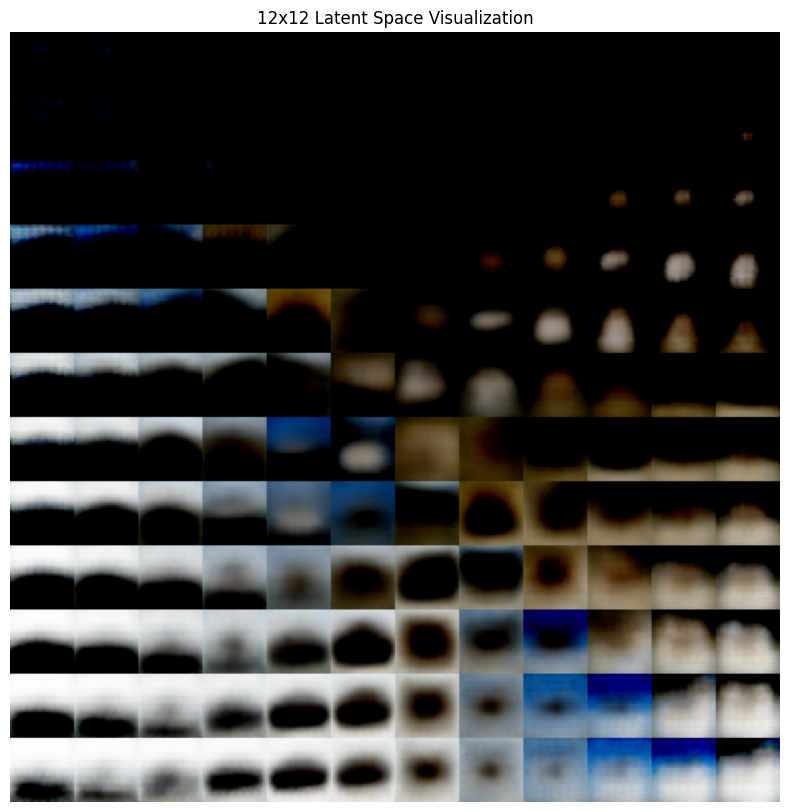

In [ ]:
def plot_latent_space_grid(model, n=12, range_lim=3):

    model.eval()
    device = next(model.parameters()).device  # automatically detect cuda/cpu

    # Create evenly spaced coordinates in latent space
    grid_x = np.linspace(-range_lim, range_lim, n)
    grid_y = np.linspace(-range_lim, range_lim, n)

    # Create a blank canvas
    figure = np.zeros((32 * n, 32 * n, 3))  # CIFAR-10 images are 32x32 RGB

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                # Combine into latent vector
                z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)

                # Decode latent vector
                recon = model.decoder(z)

                # Convert to numpy for plotting
                recon_img = recon.squeeze().cpu().numpy().transpose(1, 2, 0)
                recon_img = np.clip(recon_img, 0, 1)

                # Place into the big figure grid
                figure[i * 32: (i + 1) * 32,
                       j * 32: (j + 1) * 32] = recon_img

    # Plot the final 12x12 grid
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.title("12x12 Latent Space Visualization")
    plt.show()

plot_latent_space_grid(model)


# Testing

Reconstruction Loss: 420.6166
KL Divergence Loss: 7.6477
Total VAE Loss: 428.2644


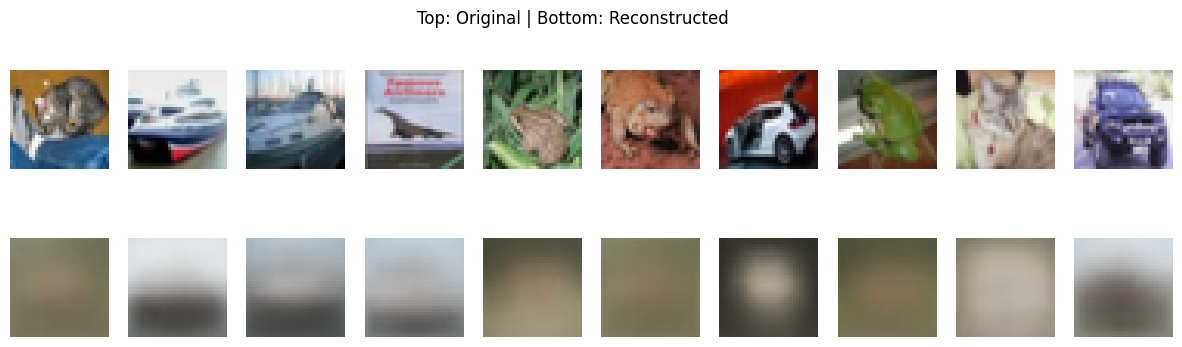

In [ ]:
def test_model(model, dataloader, num_images=10):

    model.eval()
    with torch.no_grad():
        xb, _ = next(iter(dataloader))
        xb = xb.to(device)
        kl_loss, reconstructed = model(xb)


        reconstructed_loss = criterion(xb,reconstructed)
        reconstructed_loss = reconstructed_loss/batch_size
        loss = reconstructed_loss + beta * kl_loss

        print(f"Reconstruction Loss: {reconstructed_loss.item():.4f}")
        print(f"KL Divergence Loss: {kl_loss.item():.4f}")
        print(f"Total VAE Loss: {loss.item():.4f}")

        reconstructed = reconstructed.cpu()

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.transpose((xb[i].cpu() * 0.5 + 0.5).numpy(), (1, 2, 0)))
        plt.axis("off")
        # Reconstructed
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(np.transpose((reconstructed[i] * 0.5 + 0.5).numpy(), (1, 2, 0)))
        plt.axis("off")

    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()

test_model(model,test_loader)

# Beta = 1 ld = 2

Next Ill show what happens when you have Beta = 1 with 2 latent dimensions, you will see really blurry images and results do to the limited capacity or representation of only dimensions in the latent space:

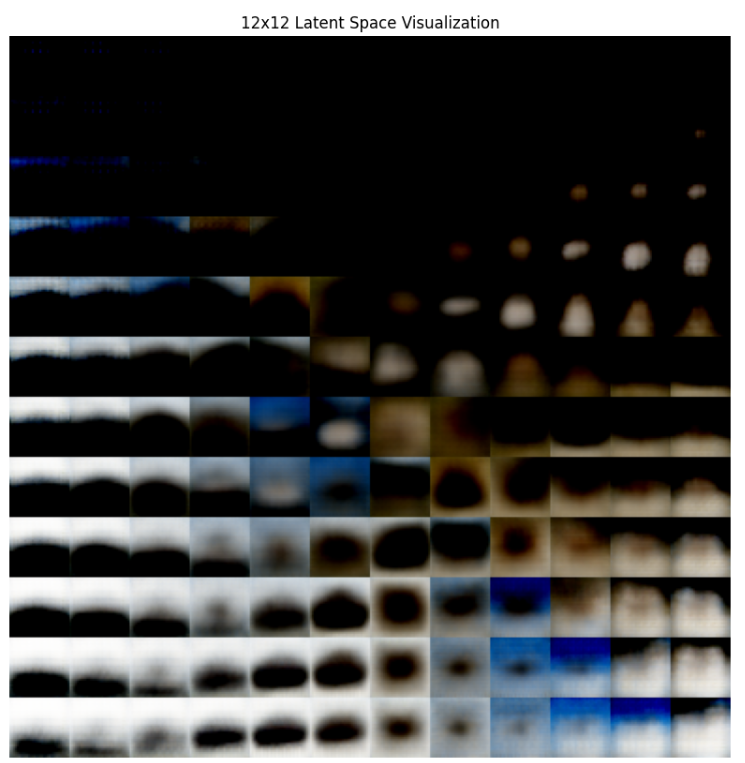
)

This would likely be the 2x2 latnet dimension representation, which really only captures blurry color features and not well-defined shapes.

The information of the last 5 epochs is as follows (Note: we started at a learning parameter = 0.001, but the scheduler I established reduced it):



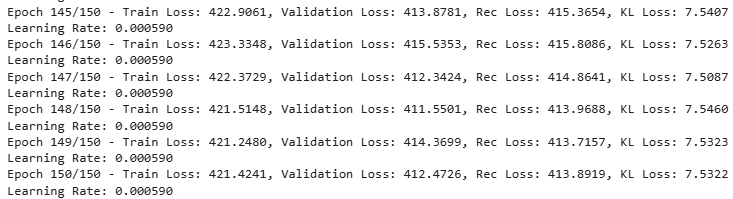

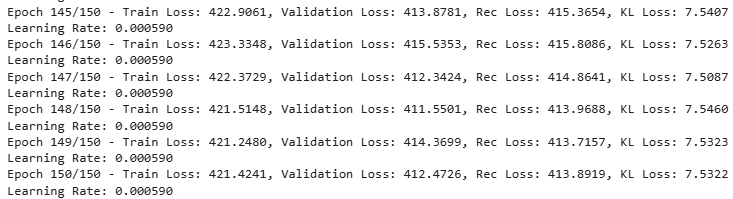

Finally , this is how the test results look like:

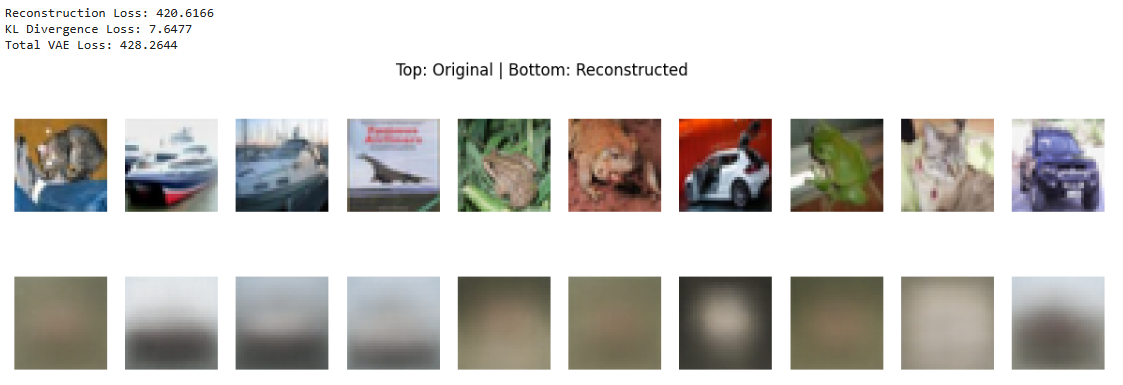

# Beta = 3 ld=2

Next we have Beta=3, and on this case, the reconstruction loss actually became bigger, so the total loss is bigger. Its still really blurry, so not so indestinguishble from its predeccesor:

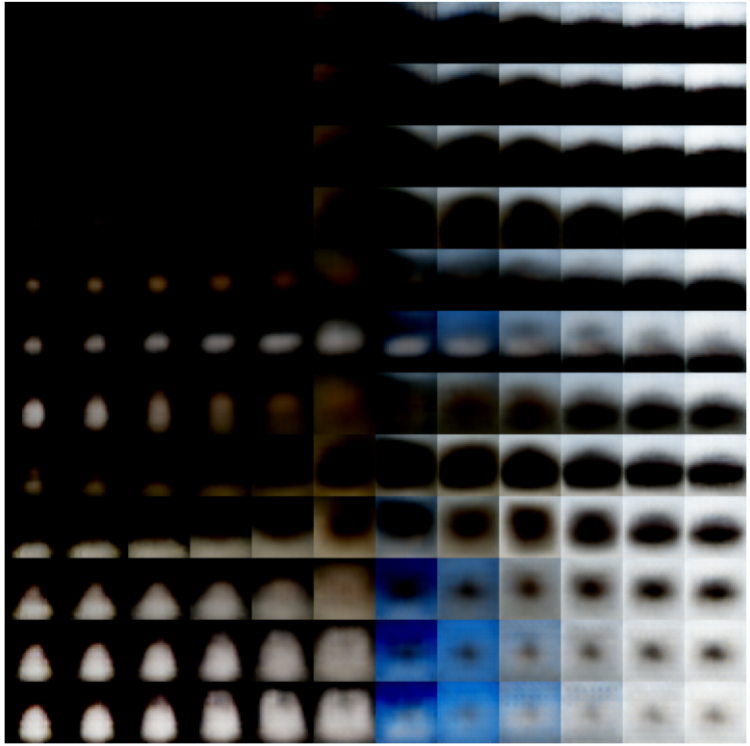

The latent space seems to have a different direction and representation of feautures that are more organized

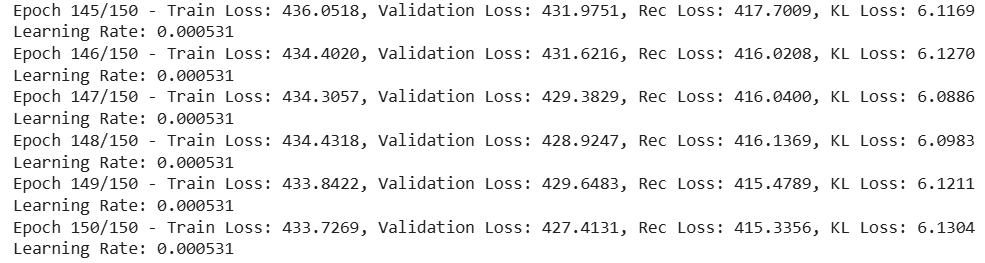

The information of the last 5 epochs shows a loss that is essentially bigger than Beta= 1. But on the model itself , there are alot of improvements, and the learning is done effectively.

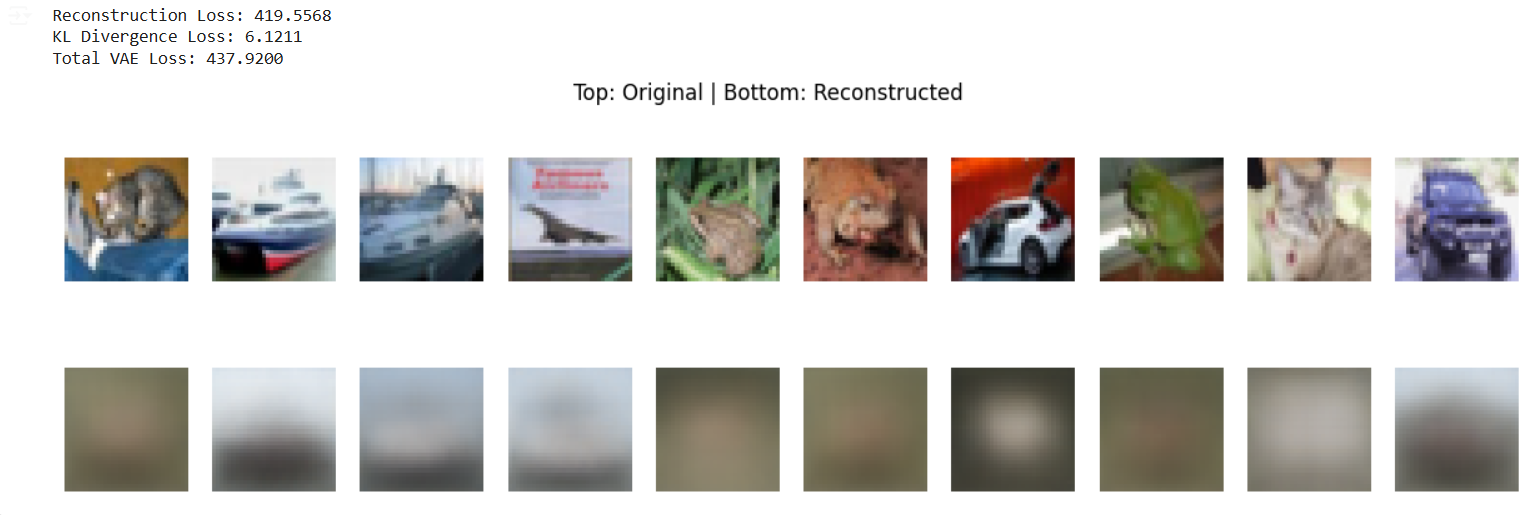

As for the Test , as you can see it has a bigger loss than Beta=1, though there is to accept the images still have the same blurriness as in the first one and look almost identical

# Beta = 0.2 ld = 2

This one performed significantly better than the last 2, and even though its also blurry, you can even start noticing some few details from the images.

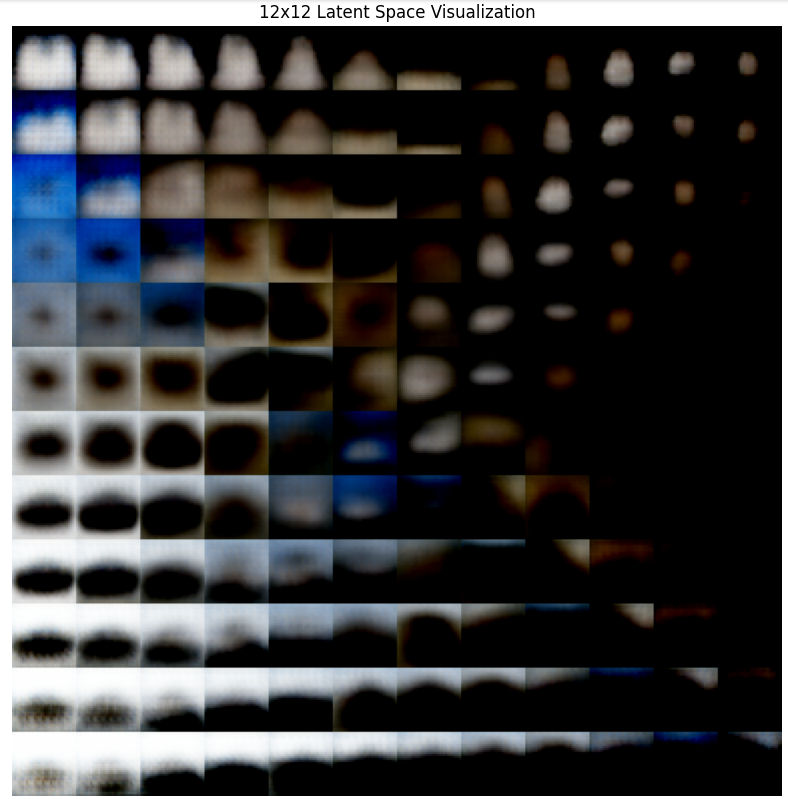

The latent space looks richer and more so like a distribution for starters, and it depicts way more features than the last two.

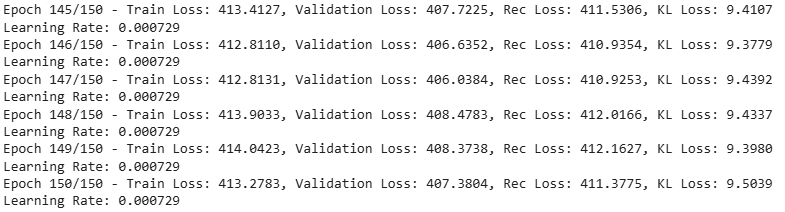

Its Loss is also significantly less than the 420-430 of the last two betas, thus we can assume a smaller beta a better development

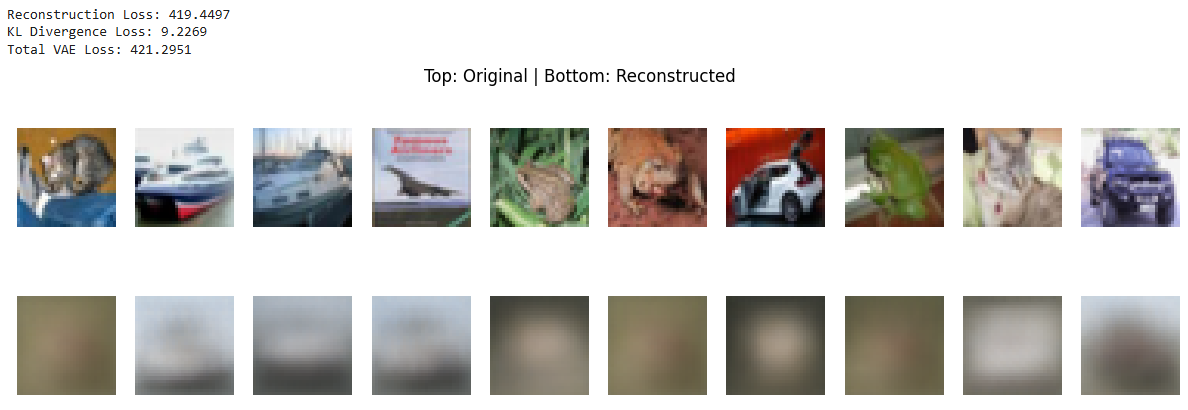

Finally , though the images stil look blurry , they have more color and factions than the last two, some images actually look different compared to the other example if you carefully look at them.

# Beta = 8 ld = 2 (Poor Performing Beta)

I have realized that the bigger the beta , the worse the model perform, I got that information from my last experiments. You will observe that when beta takes a high value such as 8, not only is the loss error function high, but it also (even on its bluriness) is even more blurry than the last ones ive shown.

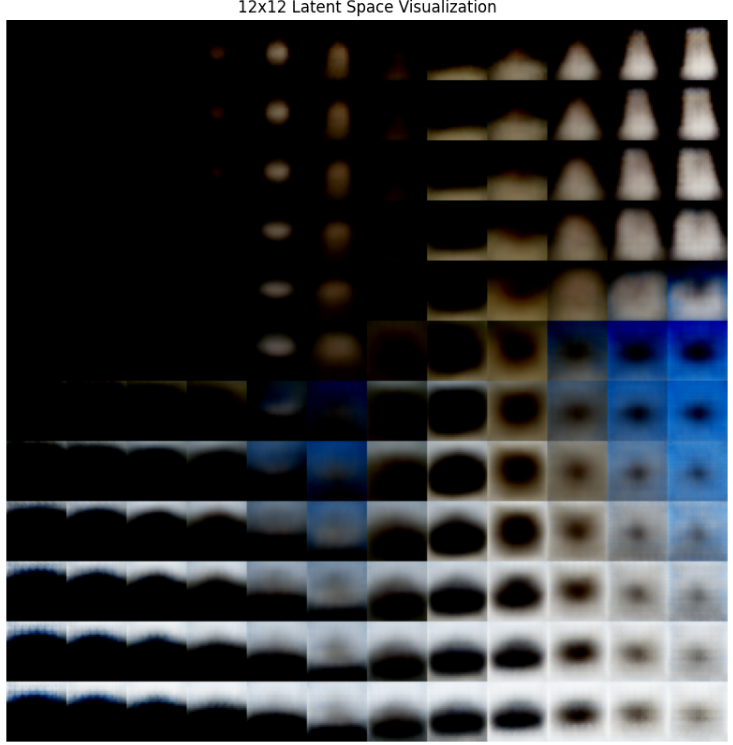

The space visualization is similar to beta=3 but its a bit more poor.

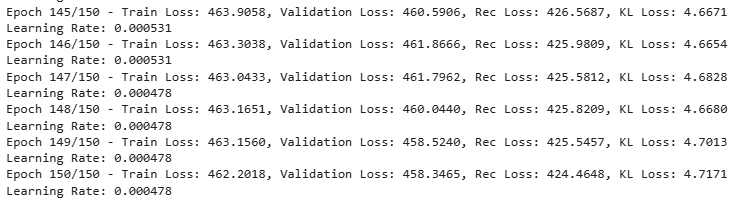

The loss never really even grasped the values of previoustotal losses, despite having a small KL value (Showing how undistributed the space really is)

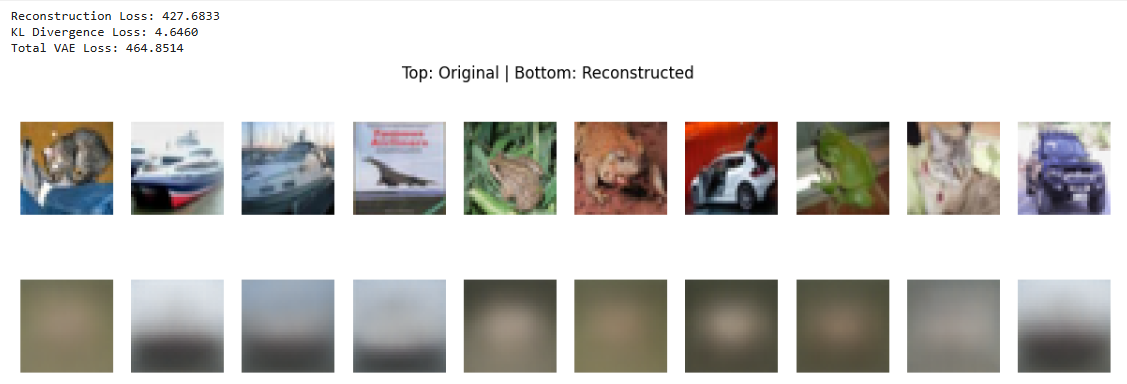

Finally , we can observe how the loss spiked up to 464!!! , its intersting how poor the visualizations are.

# Beta = 0.2 ld = 164

Finally , I did an experiment where I increased the number of dimensions in the latent space to 164. I used the best performing Beta and the results are amazing!! There is obviosly no space visualization on a 12x12 grid, but look a the results:

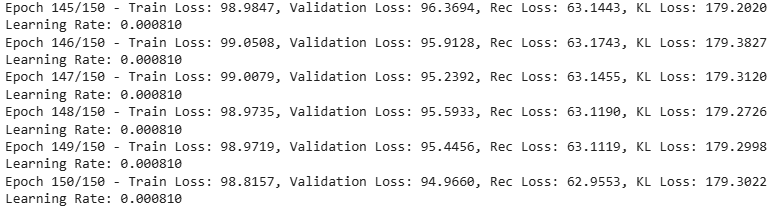

Ive done tests on 164 before, but this is the first one with a Loss < 100, which is a significant improvement. Changing Beta to a smaller value really Optimized my model

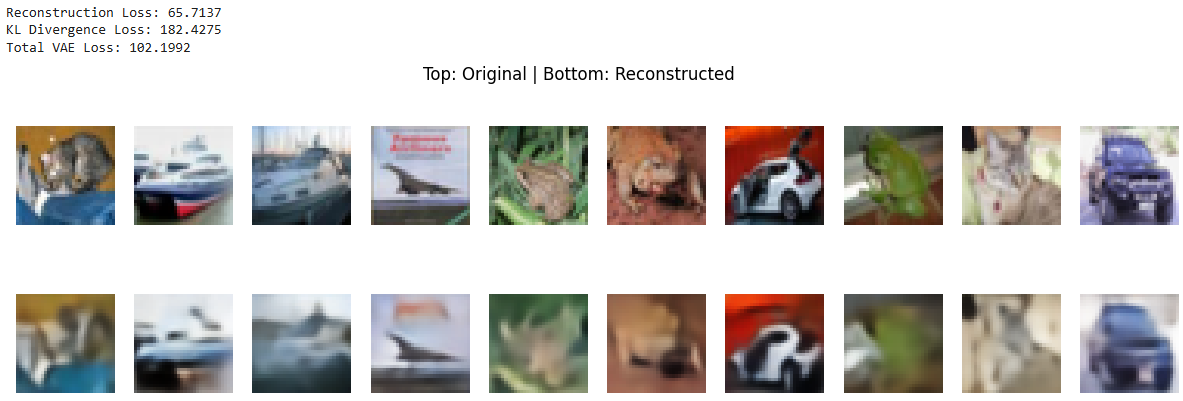

Finally, you can observe alot of color and similar features. I think that with an even bigger number of latent dimensions it could really replicae the image precisely and exactly.

In conclusion , the most optimal beta I found was beta=0.2 from the 4 betas I tried.